# Group 16 : Chandana Budaati(1002087323), Sanjana Potluri(1002147971), Deepthi Burada(1002034183), Varshith Konduru(1002132051)

https://colab.research.google.com/drive/120NJh-6AWCfb5Jxniiys_ixzl-5Lzjup?usp=sharing

# 1.1 Loading the CIFAR10 dataset

In [ ]:
# Import required libraries

import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torchvision

# Load the CIFAR10 dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Shuffle and Split the Dataset

In [24]:
# Shuffle the Train Set before splitting
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# 90% train set
train_split = int(len(trainset)*0.90)
# Split the dataset as train set and validation set
trainset, validation_set = torch.utils.data.random_split(trainset, [train_split, len(trainset) - train_split])

# Use the valloader and load the validation_set
valloader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=True, num_workers=2)

# Create empty train_img and train_lbl lists
train_img = []
train_lbl = []
# For every train image append the shape and label
for image, label in trainloader:
    train_img.append(image.view(image.shape[0], -1).numpy())
    train_lbl.append(label.numpy())
# Collect all the train images in one variable
train_img = np.concatenate(train_img, axis=0)
train_img = train_img.T
train_lbl = np.concatenate(train_lbl, axis=0)

# Create empty lists
val_img = []
val_lbl = []
# For every validation image append the shape and label
for image, label in valloader:
    val_img.append(image.view(image.shape[0], -1).numpy())
    val_lbl.append(label.numpy())

# Collect all the validation images in one variable
val_img = np.concatenate(val_img, axis=0)
val_img = val_img.T
val_lbl = np.concatenate(val_lbl, axis=0)

# 1.2 Implementing the Network

In [25]:
# Define class Neural Network
class NeuralNetwork:
    def __init__(self, layer_dimensions):
        self.parameters = {}
        self.L = len(layer_dimensions)
        self.n = 0
        self.costs = []
        self.layer_dimensions = layer_dimensions

        for i in range(1, self.L):
            self.parameters["W" + str(i)] = np.random.randn(layer_dimensions[i], layer_dimensions[i - 1]) * np.sqrt(2 / layer_dimensions[i - 1])
            self.parameters["b" + str(i)] = np.zeros((layer_dimensions[i], 1))

# Define affineForward
    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache
# Define the activationForward
    def activationForward(self, A_prev, W, b):
        Z, linear_cache = self.affineForward(A_prev, W, b)
        A = np.maximum(0, Z) # ReLU activation function
        cache = (linear_cache, Z)
        return A, cache
# Define softmax
    def softmax(self, Z):
        e_Z = np.exp(Z - np.max(Z))
        return e_Z / (e_Z.sum(axis = 0, keepdims = True) + 1e-8)
# Define forwardPropagation
    def forwardPropagation(self, X):
        caches = []
        A = X

        # Inrange up to the last layer of the neural network
        for l in range(1, self.L):
            A_prev = A
            A, cache = self.activationForward(A_prev, self.parameters["W" + str(l)], self.parameters["b" + str(l)])
            caches.append(cache)
         # Apply Softmax for the last layer of the neural network
        AL = self.softmax(A)
        return AL, caches

# Define costFunction and returns cost
    def costFunction(self, AL, y):
        #Exploding Gradients Problem Occured due to unprecidented values (e.g., log of a negative number, division by zero)
        m = y.shape[1]
        cost = -(1 / m) * np.sum(y * np.log(AL + 1e-8)) #provided small positive to counter the issue.
        cost = np.squeeze(cost)
        return cost
# Define affineBackward
    def affineBackward(self, dA_prev, cache):
        linear_cache, Z = cache
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dZ = np.array(dA_prev, copy=True)
        dZ[Z <= 0] = 0
        # implementing gradient clipping to limit the magnitude of gradients to avoid the explosion
        np.clip(dZ, -1e10, 1e10, out=dZ)
        dW = (1 / m) * np.dot(dZ, A_prev.T)
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W.T, dZ)
        return dA, dW, db
# Define backPropagation
    def backPropagation(self, dAL, Y, caches):
        grads = {}
        L = len(caches)
        m = dAL.shape[1]

        # Initialize the backpropagation of the neural network
        current_cache = caches[L - 1]
        linear_cache, Z = current_cache
        dZ = dAL - Y   # derivative of the cost with respect to Z
        A_prev, W, b = linear_cache
        m = A_prev.shape[1]
        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = dA_prev, dW, db

        for l in reversed(range(L-1)): # all the other layers
            current_cache = caches[l]
            grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = self.affineBackward(grads["dA" + str(l + 1)], current_cache)

        return grads
# define updateParameters
    def updateParameters(self, grads, alpha):
        for l in range(self.L - 1):
            # implement gradient clipping to limit the magnitude of gradients to avoid the explosion
            np.clip(grads["dW" + str(l + 1)], -1e10, 1e10, out=grads["dW" + str(l + 1)])
            np.clip(grads["db" + str(l + 1)], -1e10, 1e10, out=grads["db" + str(l + 1)])
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - alpha * grads["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - alpha * grads["db" + str(l + 1)]
    # Define one-hot encoder
    def one_hot(self, Y, num_classes):
      one_hot_Y = np.eye(num_classes)[Y.reshape(-1)]
      return one_hot_Y

    # Define random_mini_batches
    def random_mini_batches(self, X, Y, mini_batch_size = 64, seed = 0):
        m = X.shape[1]
        mini_batches = []

        # Partition (X, Y)
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches

        for k in range(0, num_complete_minibatches):
            mini_batch_X = X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
            mini_batch_Y = Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handles the end case
        if m % mini_batch_size != 0:
            mini_batch_X = X[:, num_complete_minibatches * mini_batch_size : m]
            mini_batch_Y = Y[:, num_complete_minibatches * mini_batch_size : m]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches # return mini_batches

# Define train function
    def train(self, X, Y, X_val, Y_val, iters=1000, alpha=0.0001,  batch_size=64):
        train_costs = []
        val_costs = []
        train_accs = []
        val_accs = []
        Y = self.one_hot(Y,10).T
        Y_val_one_hot = self.one_hot(Y_val,10).T

        for i in range(0, iters+1):
            minibatches = self.random_mini_batches(X, Y, mini_batch_size = batch_size)
            for minibatch in minibatches:
              (minibatch_X, minibatch_Y) = minibatch
              AL, caches = self.forwardPropagation(minibatch_X)
              cost = self.costFunction(AL, minibatch_Y)
              grads = self.backPropagation(AL, minibatch_Y, caches)
              self.updateParameters(grads, alpha)

            val_AL, _ = self.forwardPropagation(X_val)
            val_cost = self.costFunction(val_AL, Y_val_one_hot)

            train_costs.append(cost)
            val_costs.append(val_cost)

            # Train accuracy
            AL, caches = self.forwardPropagation(X)
            train_pred = np.argmax(AL, axis=0)
            train_true = np.argmax(Y, axis=0)
            train_acc = np.mean(train_pred == train_true)

            # Validation accuracy
            val_pred, _ = self.forwardPropagation(X_val)
            val_pred = np.argmax(val_pred, axis=0)
            val_true = np.argmax(Y_val_one_hot, axis=0)
            val_acc = np.mean(val_pred == val_true)

            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if i % 5 == 0:  # printing every 5 iterations
                print(f"Epoch {i}/{iters}, Train Cost: {cost}, Train Accuracy: {train_acc}, Validation Cost: {val_cost}, Validation Accuracy: {val_acc}")

        return train_costs, train_accs, val_costs, val_accs

# Plot of Train loss, Validation loss, Train accuracy, Validation accuracy
    def plot(self, train_accs, val_accs, train_costs, val_costs):
        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_costs, label="Train loss")
        plt.plot(val_costs, label="Validation loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label="Train accuracy")
        plt.plot(val_accs, label="Validation accuracy")
        plt.legend()
        plt.show()

# Predit the network
    def predict(self, X):
        AL, cache = self.forwardPropagation(X)
        y_pred = np.argmax(AL, axis=0)
        return y_pred


In [26]:
# Setting up and training the neural network for image classification.
# Training the network
nn_x = train_img.shape[0]
nn_a1 = 256
nn_a2 = 128
nn_a3 = 64
nn_y = 10
layers_dims = (nn_x, nn_a1, nn_a2, nn_a3, nn_y)
net = NeuralNetwork(layers_dims)
train_costs, train_accs, val_costs, val_accs = net.train(train_img,train_lbl, val_img, val_lbl, iters = 100, alpha = 0.001)

predictions = net.predict(val_img)

Epoch 0/100, Train Cost: 1.9501164504790331, Train Accuracy: 0.29274, Validation Cost: 2.005939552495093, Validation Accuracy: 0.3004
Epoch 5/100, Train Cost: 1.508413466992156, Train Accuracy: 0.41334, Validation Cost: 1.6811745248061387, Validation Accuracy: 0.4144
Epoch 10/100, Train Cost: 1.3192363103115743, Train Accuracy: 0.45366, Validation Cost: 1.5654331799495138, Validation Accuracy: 0.4504
Epoch 15/100, Train Cost: 1.1965777477213975, Train Accuracy: 0.48126, Validation Cost: 1.4817218577417857, Validation Accuracy: 0.4838
Epoch 20/100, Train Cost: 1.0898447009871244, Train Accuracy: 0.50542, Validation Cost: 1.4141075511705887, Validation Accuracy: 0.5088
Epoch 25/100, Train Cost: 0.9823976637539057, Train Accuracy: 0.5271, Validation Cost: 1.355950247609906, Validation Accuracy: 0.5282
Epoch 30/100, Train Cost: 0.8816060084660617, Train Accuracy: 0.5458, Validation Cost: 1.3053469321593818, Validation Accuracy: 0.5512
Epoch 35/100, Train Cost: 0.7941562712163353, Train Acc

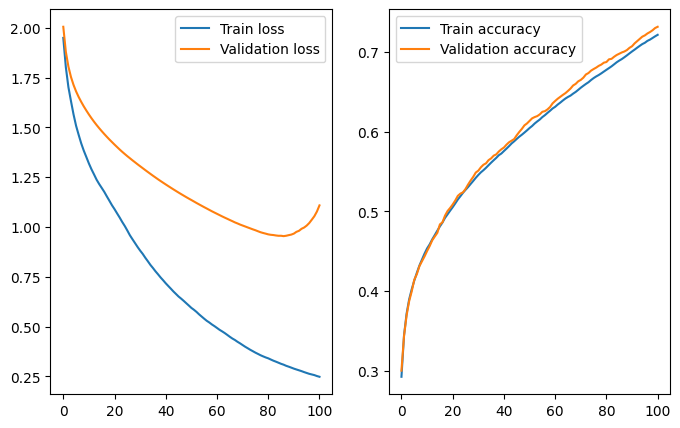

In [27]:
# Plot of Train loss, Validation loss, Train accuracy, Validation accuracy
net.plot(train_accs, val_accs, train_costs, val_costs)


# Test Accuracy

In [28]:
# Create empty lists
test_img = []
test_lbl = []
# Load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)
# Append test images and labels
for image, label in testloader:
    test_img.append(image.view(image.shape[0], -1).numpy())
    test_lbl.append(label.numpy())
test_img = np.concatenate(test_img, axis=0)
test_img = test_img.T
test_lbl = np.concatenate(test_lbl, axis=0)

# Predict the test images
test_predictions = net.predict(test_img)

# Print test accuracy
test_accuracy = np.mean(test_predictions == test_lbl)
print('Test data accuracy: ' + str(test_accuracy))

Test data accuracy: 0.5157


# 1.3 Predicting

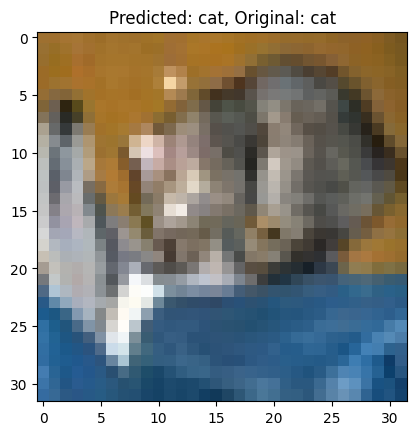

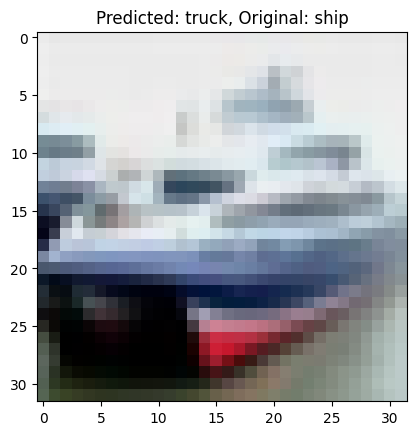

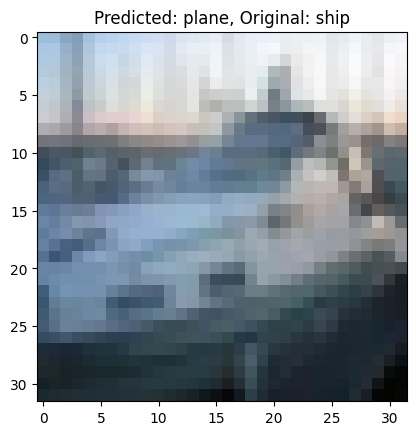

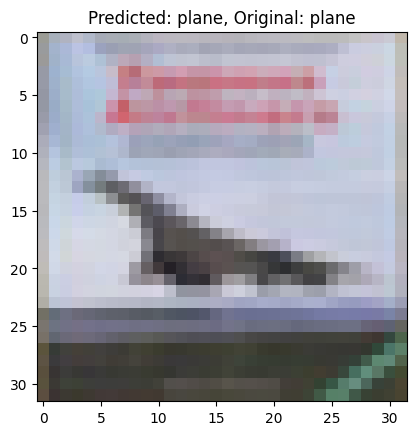

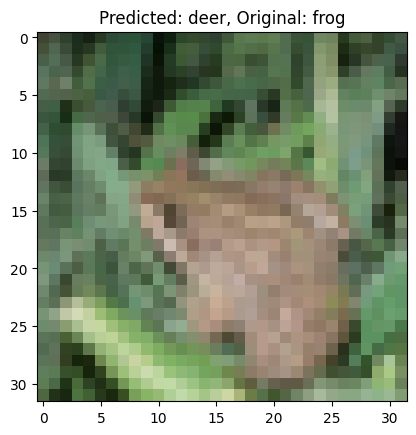

In [29]:
# Define Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# Predict the images
def display_images_predictions(model, dataset, num_images=5):
    for i in range(num_images):
        image, label = dataset[i]
        image_unsqueezed = image.unsqueeze(0)
        image_flattened = image_unsqueezed.view(image_unsqueezed.shape[0], -1)
        y_pred = model.predict(image_flattened.T)
        imshow(image)
        plt.title(f'Predicted: {classes[y_pred[0]]}, Original: {classes[label]}')
        plt.show()
# Display the images predicted
display_images_predictions(net, testset, num_images=5)